In [1]:
import matplotlib.pyplot as plt
from ekarus.e2e.single_stage_ao_class import SingleStageAO
import xupy as xp
from ekarus.e2e.utils.image_utils import reshape_on_mask
from numpy.ma import masked_array


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
tn = 'slaving_single_stage'
amp = 0.02

ssao = SingleStageAO(tn)
ssao.initialize_turbulence()
KL, m2c = ssao.define_KL_modes(ssao.dm, zern_modes=5)
ssao.pyr.set_modulation_angle(modulationAngleInLambdaOverD=3.0)
Rec, _ = ssao.compute_reconstructor(ssao.sc, KL, ssao.pyr.lambdaInM, amps=amp, save_prefix='')
ssao.sc.load_reconstructor(Rec,m2c)

lambdaRef = ssao.pyr.lambdaInM

Initializing devices ...
Fried parameter is: 5.5 [cm]
Modulating 3 [lambda/D] with 20 modulation steps


Text(0.5, 1.0, 'Difference')

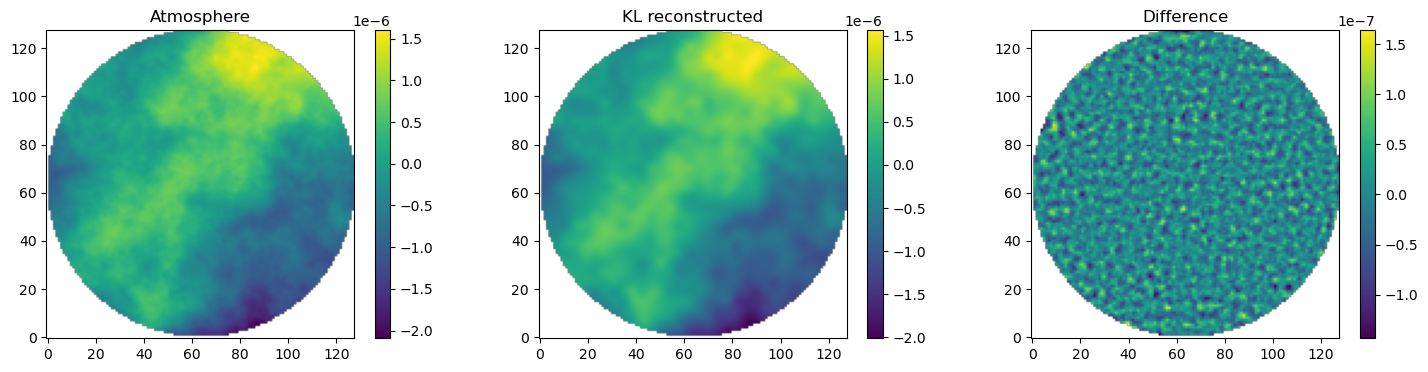

In [3]:
atmo_phase = ssao.get_phasescreen_at_time(0)
atmo_phase -= xp.mean(atmo_phase[~ssao.cmask])

phi = atmo_phase[~ssao.cmask]
modes = xp.linalg.pinv(KL).T @ phi

rec_phi = KL.T @ modes
rec_phase = reshape_on_mask(rec_phi, ssao.cmask)

delta_phase = atmo_phase - rec_phase

sh = 1.0

plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.imshow(masked_array(xp.asnumpy(atmo_phase),xp.asnumpy(ssao.cmask)), origin='lower')
plt.colorbar(shrink=sh)
plt.title('Atmosphere')
plt.subplot(1,3,2)
plt.imshow(masked_array(xp.asnumpy(rec_phase),xp.asnumpy(ssao.cmask)), origin='lower')
plt.colorbar(shrink=sh)
plt.title('KL reconstructed')
plt.subplot(1,3,3)
plt.imshow(masked_array(xp.asnumpy(delta_phase),xp.asnumpy(ssao.cmask)), origin='lower')
plt.colorbar(shrink=sh)
plt.title('Difference')

In [4]:
# phi_fit = delta_phase[~ssao.cmask]
# phi_fit *= 2*xp.pi/lambdaRef

# off_slopes = ssao._get_slopes(ssao.sc, KL, lambdaRef, amp, phase_offset=phi_fit)
# ref_slopes = ssao._get_slopes(ssao.sc, KL, lambdaRef, amp)

In [5]:
# ref_IM = ref_slopes.T
# off_IM = off_slopes.T

# plt.figure()
# plt.plot(xp.asnumpy(xp.std(ref_IM,axis=0)),label='reference')
# plt.plot(xp.asnumpy(xp.std(off_IM,axis=0)),label='offset')
# plt.legend()
# plt.grid()


In [6]:
# off_Rec = xp.linalg.pinv(off_IM)
# ref_Rec = xp.linalg.pinv(ref_IM)

In [7]:
# Nmodes= xp.shape(KL)[0]
# electric_field_amp = 1-ssao.cmask
# lambdaOverD = lambdaRef/ssao.pupilSizeInM

# opt_gains = xp.zeros(Nmodes)
# ref_gains = xp.zeros(Nmodes)

# for i in range(Nmodes):
#     print(f'\rMode {i:1.0f}/{Nmodes:1.0f}',end='\r',flush=True)
#     mode_phase = reshape_on_mask(KL[i,:]*amp + phi_fit, ssao.cmask)
#     input_field = electric_field_amp * xp.exp(1j*mode_phase)
#     slope = ssao.sc.compute_slopes(input_field, lambdaOverD, None)
#     rec_mode = off_Rec @ slope
#     opt_gains[i] = rec_mode[i]/amp
#     rec_mode = ref_Rec @ slope
#     ref_gains[i] = rec_mode[i]/amp


In [8]:
# plt.figure()
# plt.plot(xp.asnumpy(ref_gains),'-.',label='0-point calibration')
# plt.xlim([0,200])
# plt.grid()

In [9]:
# plt.figure()
# plt.plot(xp.asnumpy(ref_gains),'-.',label='0-point calibration')
# plt.plot(xp.asnumpy(opt_gains),'-.',label='offset calibration')
# plt.legend()
# plt.xscale('log')
# plt.grid()

In [10]:
def get_opt_gains_at_time(ssao,tt,KL,amp):
    atmo_phase = ssao.get_phasescreen_at_time(tt)
    atmo_phase -= xp.mean(atmo_phase[~ssao.cmask])
    phi = atmo_phase[~ssao.cmask]
    modes = xp.linalg.pinv(KL).T @ phi
    rec_phi = KL.T @ modes
    rec_phase = reshape_on_mask(rec_phi, ssao.cmask)
    # delta_phase = atmo_phase - rec_phase
    # phi_fit = delta_phase[~ssao.cmask]
    phi_fit = rec_phase[~ssao.cmask]
    phi_fit *= 2*xp.pi/ssao.pyr.lambdaInM
    Nmodes= xp.shape(KL)[0]
    electric_field_amp = 1-ssao.cmask
    lambdaOverD = ssao.pyr.lambdaInM/ssao.pupilSizeInM
    opt_gains = xp.zeros(Nmodes)
    for i in range(Nmodes):
        print(f'\rMode {i:1.0f}/{Nmodes:1.0f}',end='\r',flush=True)
        mode_phase = reshape_on_mask(KL[i,:]*amp + phi_fit, ssao.cmask)
        pull_mode_phase = reshape_on_mask(-KL[i,:]*amp + phi_fit, ssao.cmask)
        input_field = electric_field_amp * xp.exp(1j*mode_phase)
        pull_input_field = electric_field_amp * xp.exp(1j*pull_mode_phase)
        push_slope = ssao.sc.compute_slopes(input_field, lambdaOverD, None)
        pull_slope = ssao.sc.compute_slopes(pull_input_field, lambdaOverD, None)
        dslope = (push_slope - pull_slope)/2
        rec_mode = ssao.sc.Rec @ dslope
        opt_gains[i] = rec_mode[i]/amp
    return opt_gains


In [11]:
amp = 1e-9*2*xp.pi/lambdaRef
print(amp)

opt_gains0 = get_opt_gains_at_time(ssao, 0, KL, amp)
opt_gains1 = get_opt_gains_at_time(ssao, 0.1, KL, amp)
opt_gains2 = get_opt_gains_at_time(ssao, 0.2, KL, amp)
opt_gains3 = get_opt_gains_at_time(ssao, 0.3, KL, amp)

0.008377580409572781


In [16]:
opt_gains4 = get_opt_gains_at_time(ssao, 0.4, KL, amp)

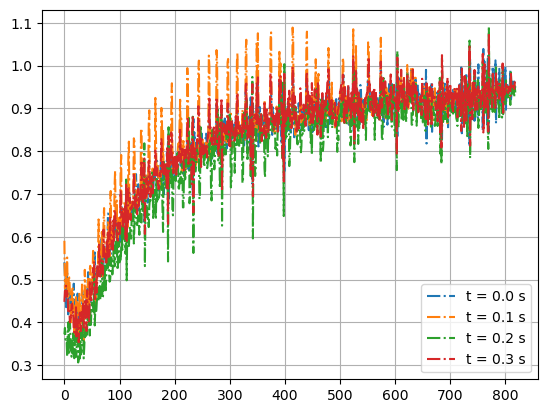

In [12]:
plt.figure()
plt.plot(xp.asnumpy(opt_gains0),'-.',label='t = 0.0 s')
plt.plot(xp.asnumpy(opt_gains1),'-.',label='t = 0.1 s')
plt.plot(xp.asnumpy(opt_gains2),'-.',label='t = 0.2 s')
plt.plot(xp.asnumpy(opt_gains3),'-.',label='t = 0.3 s')
plt.legend()
plt.grid()
# plt.xlim([0,10])
# plt.ylim([0.8,1.0])

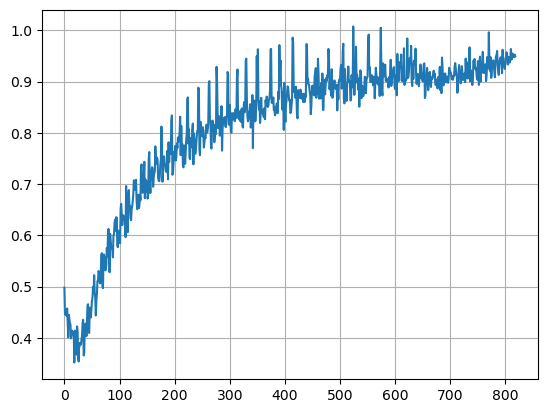

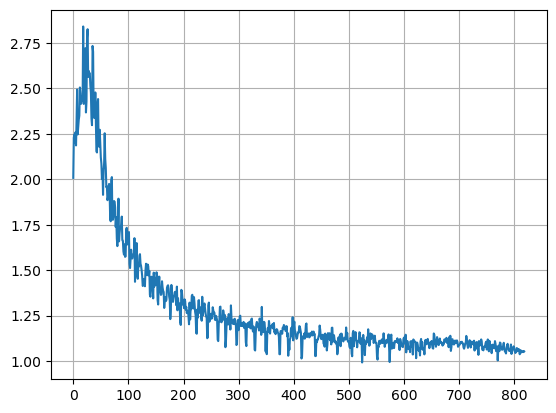

In [18]:
opt_gains = xp.mean(xp.vstack([opt_gains0,opt_gains1,opt_gains2,opt_gains3,opt_gains4]),axis=0)

plt.figure()
plt.plot(xp.asnumpy(opt_gains))
plt.grid()

plt.figure()
plt.plot(xp.asnumpy(1/opt_gains))
plt.grid()